Simplex Regression with Trend Filtering
=========================================

This notebook showcase a structured regression method which defines a predictor as an average of several values (e.g. baseline methods), with a temporal regularization which enforces piecewise constant choices (often called "trend filtering").
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Simplex Regression
=========================================

In the following $n$ is the number of "temporal" samples (for instance angle) and $m$ the number of methods.

In [0]:
n = 360  # angles
m = 4 # methods

The set of regression weights is $W \in \RR^{n \times m}$ and the linear regression of $y_i$ at time (or angle $i$) reads
$$
    y_i \approx \sum_{j} M_{i,j} W_{i,j}.
$$
Here $M_{i,j}$ is the output of method $j$ at time $i$.

The constraint is that for each time $i$, the set of weights $W_{i,\cdot} = (W_{i,j})_{j=1}^m$ is in the probability simplex
$$
    W_{i,j} \geq 0 \qandq
    \sum_j W_{i,j}=1.
$$
We re-write this constraint conveniently as $W \geq 0, W 1_m = 1_n$.

We use a $\ell^2$ regression penalized by the sum of absolute value of temporal differences
$$
    \umin{W \geq 0, W 1_m = 1_n}
    \sum_i \Big( y_i - \sum_{j} M_{i,j} W_{i,j} \Big)^2
    + \lambda
    \sum_{i,j} |W_{i+1,j}-W_{i,j}|
$$

Generate random data $M$ and $y$.

In [0]:
M = np.random.randn(n,m)
y = np.random.randn(n)

Define the optimized over variable $W$.

In [0]:
W = cp.Variable((n,m))

Define the set constraints (vectors in the simplex).

In [0]:
u = np.ones((m,1))
v = np.ones((n,1))
U = [0 <= W, cp.matmul(W,u)==v]

Regularization parameter $\lambda$. Increase this value makes the resulting weights more and more constant.

In [0]:
Lambda = 10

Solve the minimization using CVXPY

In [0]:
objective = cp.Minimize( cp.sum( ( cp.sum(cp.multiply(M,W), axis=1) - y )**2 ) + Lambda * cp.sum( cp.abs(W[1:,:] - W[:-1,:]) )  )
prob = cp.Problem(objective, U)
result = prob.solve()

Display the evolution of the weights associated to the three first variables as function of time.

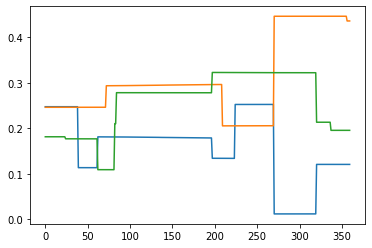

In [8]:
Wm = W.value
plt.plot(Wm[:,0])
plt.plot(Wm[:,1])
plt.plot(Wm[:,2]);

Group-Lasso Regularization
============================

It is possible to enforce that breakpoints in time are somehow "synchronized" by using a group lasso regularization.
$$
    \umin{W \geq 0, W 1_m = 1_n}
    \sum_i \Big( y_i - \sum_{j} M_{i,j} W_{i,j} \Big)^2
    + \lambda
    \sum_{i} \sqrt{ \sum_j|W_{i+1,j}-W_{i,j}|^2 }
$$

In [0]:
Lambda = 20
objective = cp.Minimize( cp.sum( ( cp.sum(cp.multiply(M,W), axis=1) - y )**2 ) + Lambda * cp.mixed_norm( W[1:,:] - W[:-1,:], 2, 1 ) )
prob = cp.Problem(objective, U)
result = prob.solve()

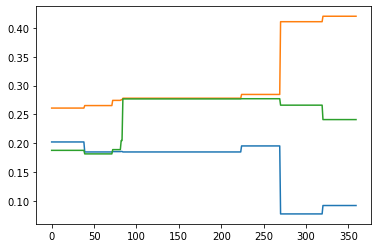

In [10]:
Wm = W.value
plt.plot(Wm[:,0])
plt.plot(Wm[:,1])
plt.plot(Wm[:,2]);

We now show the evolution of the solution for varying $\lambda$.

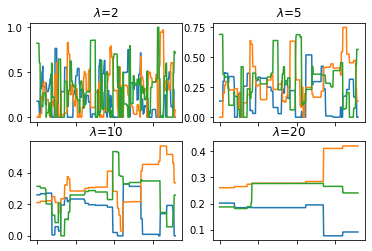

In [11]:
Lambda_list = np.array([2, 5, 10, 20])
for i in np.arange(0,4):
  Lambda = Lambda_list[i];
  objective = cp.Minimize( cp.sum( ( cp.sum(cp.multiply(M,W), axis=1) - y )**2 ) + Lambda * cp.mixed_norm( W[1:,:] - W[:-1,:], 2, 1 ) )
  prob = cp.Problem(objective, U)
  result = prob.solve()
  Wm = W.value
  ax1=plt.subplot(2, 2, i+1)
  plt.plot(Wm[:,0])
  plt.plot(Wm[:,1])
  plt.plot(Wm[:,2])
  plt.title('$\lambda$='+str(Lambda))
  ax1.set_xticklabels([])
